# THE ELASTODYAMICS PROBLEM

Author: A. Chao Correas (arturo.chaocorreas@polito.it)

# Numerical implementation in dolfinx of the optimized explicit time integrator

Import required libraries

In [1]:
import dolfinx, ufl
import numpy as np
import sympy as sp
from mpi4py import MPI
from petsc4py import PETSc
from matplotlib import pyplot as plt
import sys
sys.path.append("../utils/")

import mesh_plotter
from petsc_problems import SNESProblem

Input parameters

In [2]:
# Characteristic dimensions of the domain
geometry_parameters = {'Lx': 1., 
                       'Ly': 0.1}

# Regularization length               
material_properties = {'E':   3e3, 
                       'nu':  0.3, 
                       'rho': 1.8e-9}

# Mesh control
mesh_parameters = {'nx': 10,
                   'ny': 1}

# Time stepping control
timestepping_parameters = {'initial_time':0., 
                           'total_time':20e-6, 
                           'delta_t':1.e-8,
                           'explicit_safety_factor': 5}

# Top facet displacement
T_0 = 0.
T_1 = 2.5e-6
U_t = 1e-2

t_sp = sp.Symbol('t', real = True)
U_imp = sp.Piecewise((0, t_sp<T_0),
                     (0.5*U_t*(1-sp.cos(((t_sp-T_0)/(T_1-T_0))*sp.pi)), t_sp<=T_1),
                     (U_t, True)) 
V_imp = sp.diff(U_imp, t_sp)
A_imp = sp.diff(V_imp, t_sp)

# Body forces
Xi = np.asarray([0.,0.])

Loading on the right

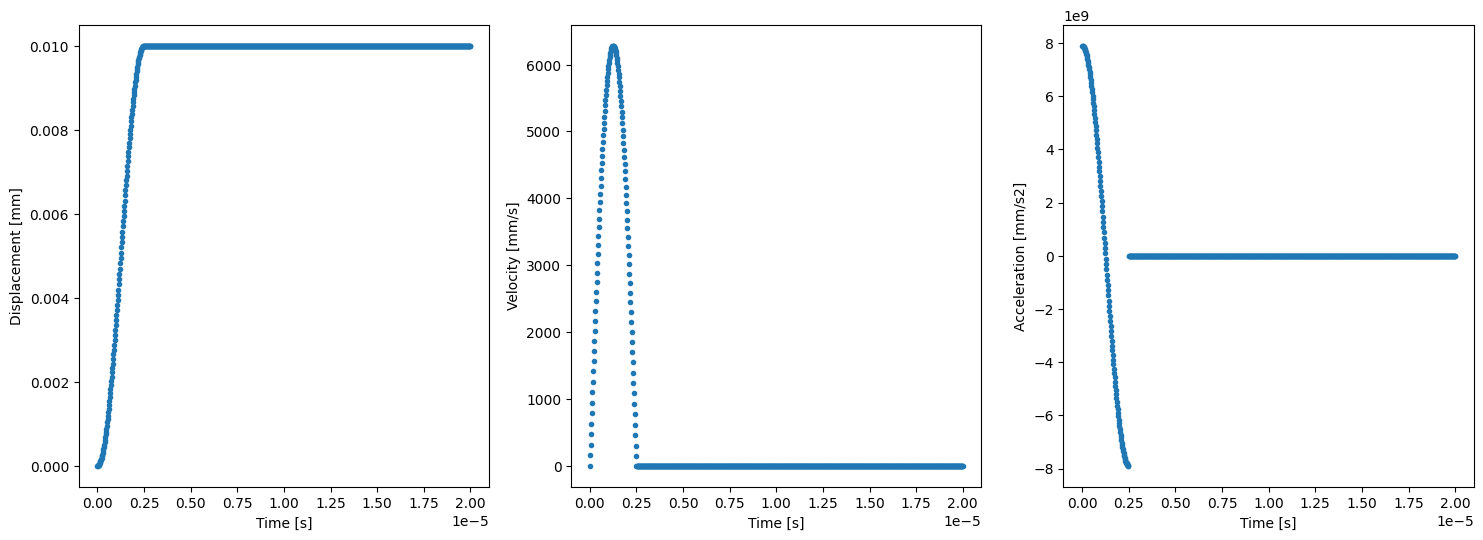

In [3]:
t_sampling = np.linspace(timestepping_parameters['initial_time'], 
                         timestepping_parameters['total_time'], 
                         1000) 
U_imp_sampling = np.zeros_like(t_sampling)
V_imp_sampling = np.zeros_like(t_sampling)
A_imp_sampling = np.zeros_like(t_sampling)

for i in enumerate (t_sampling):
    U_imp_sampling[i[0]] = U_imp.subs({t_sp:t_sampling[i[0]]})
    V_imp_sampling[i[0]] = V_imp.subs({t_sp:t_sampling[i[0]]})
    A_imp_sampling[i[0]] = A_imp.subs({t_sp:t_sampling[i[0]]})
    
fig, ax = plt.subplots(1, 3, figsize=(18,6))
ax[0].plot(t_sampling, U_imp_sampling, ls='none', marker='.')
ax[0].set_xlabel('Time [s]')
ax[0].set_ylabel('Displacement [mm]')
ax[1].plot(t_sampling, V_imp_sampling, ls='none', marker='.')
ax[1].set_xlabel('Time [s]')
ax[1].set_ylabel('Velocity [mm/s]')
ax[2].plot(t_sampling, A_imp_sampling, ls='none', marker='.')
ax[2].set_xlabel('Time [s]')
ax[2].set_ylabel('Acceleration [mm/s2]');

Mesh, geometrical regions of interest and measures

In [4]:
mesh = dolfinx.mesh.create_rectangle(MPI.COMM_WORLD, 
                                     [np.array([-geometry_parameters['Lx']/2, -geometry_parameters['Ly']/2]), 
                                      np.array([+geometry_parameters['Lx']/2, +geometry_parameters['Ly']/2])], 
                                     [mesh_parameters['nx'], mesh_parameters['ny']], 
                                     dolfinx.mesh.CellType.triangle)
# mesh_plotter(mesh)

In [5]:
h_min_local= min(dolfinx.cpp.mesh.h(mesh, mesh.topology.dim, range(mesh.topology.index_map(mesh.topology.dim).size_local))) #Minimum internodal distance h of every processor submesh
h_min = np.asarray(MPI.COMM_WORLD.gather(h_min_local, root=0)) # Gather the minimum internodal distance of every processor submesh in an array at processor 0
if MPI.COMM_WORLD.rank == 0:  #Calculate the global minimum of h at processor 0
    h_min = min(h_min)  
h_min = MPI.COMM_WORLD.bcast(h_min, root=0) #Broadcast to every processor the global minimum of h.

In [6]:
# Geometrical regions  
def top(x):
    return np.isclose(x[1], +geometry_parameters["Ly"]/2)
def bottom(x):
    return np.isclose(x[1], -geometry_parameters["Ly"]/2)
def right (x):
    return np.isclose(x[0], +geometry_parameters["Lx"]/2)
def left (x):
    return np.isclose(x[0], -geometry_parameters["Lx"]/2)

# Geometrical sets
top_facets = dolfinx.mesh.locate_entities_boundary(mesh, mesh.topology.dim-1, top)
bottom_facets = dolfinx.mesh.locate_entities_boundary(mesh, mesh.topology.dim-1, bottom)
right_facets = dolfinx.mesh.locate_entities(mesh, mesh.topology.dim-1, right)
left_facets = dolfinx.mesh.locate_entities(mesh, mesh.topology.dim-1, left)

tagged_facets = np.hstack([top_facets, bottom_facets, right_facets, left_facets])
tag_values = np.hstack([np.full_like(top_facets, 1), 
                        np.full_like(bottom_facets, 2),
                        np.full_like(right_facets, 3),
                        np.full_like(left_facets, 4)])
tagged_facets_sorted = np.argsort(tagged_facets)
mt = dolfinx.mesh.meshtags(mesh, mesh.topology.dim-1, 
                           tagged_facets[tagged_facets_sorted], 
                           tag_values[tagged_facets_sorted])

# Domain and subdomain measures
dx  = ufl.Measure("dx", domain=mesh)                         # Domain measure
ds  = ufl.Measure("ds", domain=mesh, subdomain_data=mt)      # External Boundary measure
dS  = ufl.Measure("dS", domain=mesh, subdomain_data=mt)      # External/Internal measure
n   = ufl.FacetNormal(mesh)                                  # External normal to the boundary

Function spaces, functions and system's state

In [7]:
# --------- Main functions and function spaces
element_u = ufl.VectorElement('CG', mesh.ufl_cell(), degree=1, dim=mesh.topology.dim)
V_u = dolfinx.fem.FunctionSpace(mesh, element_u)
u = dolfinx.fem.Function(V_u, name="Displacement")
u_new = dolfinx.fem.Function(V_u)
v = dolfinx.fem.Function(V_u, name="Velocity")
v_new = dolfinx.fem.Function(V_u)
a = dolfinx.fem.Function(V_u, name="Acceleration")
a_new = dolfinx.fem.Function(V_u)

# --------- Auxiliar functions
ones_a = dolfinx.fem.Function(V_u)

# --------- State of each field 
state = {"u": u,"v": v,"a": a}

Boundary conditions

In [8]:
# --------- Displacement problem -----------------------------------------------------
# Definition of the values for the blocked displacement DoFs
V_ux = V_u.sub(0)
V_uy = V_u.sub(1)

# Clamped left (ux=uy=0) 
zero_u = dolfinx.fem.Function(V_u)
blocked_dofs_left_u = dolfinx.fem.locate_dofs_geometrical(V_u, left)
bc_u_left = dolfinx.fem.dirichletbc(zero_u, blocked_dofs_left_u)

# Imposed displacement right (ux=U_imp(t))
right_ux = dolfinx.fem.Function(V_ux.collapse()[0])
blocked_dofs_top_ux = dolfinx.fem.locate_dofs_geometrical((V_ux, V_ux.collapse()[0]), right)
bc_ux_right = dolfinx.fem.dirichletbc(right_ux, blocked_dofs_top_ux, V_ux)

# Concatenate u-BCs
bcs_u = [bc_u_left, bc_ux_right]

# --------- Velocity problem -----------------------------------------------------
zero_v = dolfinx.fem.Function(V_u)
bc_v_left = dolfinx.fem.dirichletbc(zero_v, blocked_dofs_left_u)

right_vx = dolfinx.fem.Function(V_ux.collapse()[0])
bc_ux_right = dolfinx.fem.dirichletbc(right_vx, blocked_dofs_top_ux, V_ux)

bcs_v = [bc_v_left, bc_ux_right]

# --------- Acceleration problem -----------------------------------------------------
zero_a = dolfinx.fem.Function(V_u)
bc_a_left = dolfinx.fem.dirichletbc(zero_a, blocked_dofs_left_u)

right_ax = dolfinx.fem.Function(V_ux.collapse()[0])
bc_ax_right = dolfinx.fem.dirichletbc(right_ax, blocked_dofs_top_ux, V_ux)

bcs_a = [bc_a_left, bc_ax_right]


Variational magnitudes

In [9]:
t = ufl.constantvalue.ScalarValue(0.)

# Material properties
E   = dolfinx.fem.Constant(mesh, material_properties["E"])
nu  = dolfinx.fem.Constant(mesh, material_properties["nu"])
rho = dolfinx.fem.Constant(mesh, material_properties["rho"])

# Critical time increment (CFL condition)
c = np.sqrt((E.value/rho.value)*((1-nu.value)/((1+nu.value)*(1-2*nu.value)))) 
delta_t_critic = h_min/c

# Body forces
b = dolfinx.fem.Constant(mesh, Xi)

# Lame constants (Plane strain)
mu    = E / (2.0 * (1.0 + nu))
lmbda = E * nu / ((1.0 + nu) * (1.0 - 2.0 * nu))

## Infinitesimal strain tensor
eps = ufl.variable(ufl.sym(ufl.grad(u)))

## Kinetic energy density
phi = ufl.variable(0.5*rho*ufl.inner(v,v))

## Strain energy density (Linear elastic)
psi = ufl.variable(lmbda/2*ufl.tr(eps)**2 + mu*ufl.inner(eps,eps))

# Stress tensor
sigma = ufl.diff(psi, eps)

#
def delta_t (t):
    return ufl.conditional(ufl.lt(delta_t_critic/timestepping_parameters['explicit_safety_factor'],
                                   timestepping_parameters["total_time"]-t), 
                          delta_t_critic/timestepping_parameters['explicit_safety_factor'],
                          timestepping_parameters["total_time"]-t) 

# System's potential energies and Lagrangian
P_kin = phi*dx
P_str = psi*dx 
P_ext = ufl.dot(b,u)*dx 
P_tot = P_kin + P_str - P_ext

# Lagrangian derivatives
P_tot_du = ufl.derivative(P_tot, u, ufl.TestFunction(V_u)) 
P_tot_dv = ufl.derivative(P_tot, v, ufl.TestFunction(V_u))

# Residual 
Res = P_tot_dv + P_tot_du

## Iterative resolution

Mass lumping

In [10]:
M = ufl.lhs(ufl.replace(P_tot_dv,{v: ufl.TrialFunction(V_u)})) #Consistent matrix
M_lumped_form = dolfinx.fem.form(ufl.action(M, ones_a))
F_tot_form = dolfinx.fem.form(ufl.replace(-P_tot_du,{u:u_new}))

Magnitudes of interest

In [11]:
P_kin_form = dolfinx.fem.form(P_kin)
P_str_form = dolfinx.fem.form(P_str)
P_tot_form = dolfinx.fem.form(P_tot)
Fx_react_right_form = dolfinx.fem.form(ufl.inner(n,sigma*n)*ds(3))

Iterative resolution

In [12]:
# Initialization
t = ufl.constantvalue.ScalarValue(timestepping_parameters["initial_time"])

P_kin_ = []
P_str_ = []
P_ext_ = []
P_tot_ =[]
Fx_react_right_ = []
t_ = []

with u.vector.localForm() as u_local:
    u_local.set(0.)   
u.vector.ghostUpdate(addv=PETSc.InsertMode.INSERT, mode=PETSc.ScatterMode.FORWARD)

with v.vector.localForm() as v_local:
    v_local.set(0.)  
v.vector.ghostUpdate(addv=PETSc.InsertMode.INSERT, mode=PETSc.ScatterMode.FORWARD)
  
with a.vector.localForm() as a_local:
    a_local.set(0.) 
a.vector.ghostUpdate(addv=PETSc.InsertMode.INSERT, mode=PETSc.ScatterMode.FORWARD)

with zero_u.vector.localForm() as bc_local:
    bc_local.set(0.)
zero_u.vector.ghostUpdate(addv=PETSc.InsertMode.INSERT, mode=PETSc.ScatterMode.FORWARD)

with zero_v.vector.localForm() as bc_local:
    bc_local.set(0.)
zero_v.vector.ghostUpdate(addv=PETSc.InsertMode.INSERT, mode=PETSc.ScatterMode.FORWARD)

with zero_a.vector.localForm() as bc_local:
    bc_local.set(0.)
zero_a.vector.ghostUpdate(addv=PETSc.InsertMode.INSERT, mode=PETSc.ScatterMode.FORWARD)

with right_ux.vector.localForm() as bc_local:
    bc_local.set(float(U_imp.subs({t_sp:float(t.value())})))
right_ux.vector.ghostUpdate(addv=PETSc.InsertMode.INSERT, mode=PETSc.ScatterMode.FORWARD)

with right_vx.vector.localForm() as bc_local:
    bc_local.set(float(U_imp.subs({t_sp:float(t.value())})))
right_vx.vector.ghostUpdate(addv=PETSc.InsertMode.INSERT, mode=PETSc.ScatterMode.FORWARD)

with right_ax.vector.localForm() as bc_local:
    bc_local.set(float(U_imp.subs({t_sp:float(t.value())})))
right_ax.vector.ghostUpdate(addv=PETSc.InsertMode.INSERT, mode=PETSc.ScatterMode.FORWARD)
 
with ones_a.vector.localForm() as ones_local:
    ones_local.set(1.)
ones_a.vector.ghostUpdate(addv=PETSc.InsertMode.INSERT, mode=PETSc.ScatterMode.FORWARD)

M_lumped = dolfinx.fem.petsc.assemble_vector(M_lumped_form)
M_lumped.ghostUpdate(addv=PETSc.InsertMode.ADD, mode=PETSc.ScatterMode.REVERSE)
M_lumped.ghostUpdate(addv=PETSc.InsertMode.INSERT, mode=PETSc.ScatterMode.FORWARD)
     
## ------------- TIME STEPPING

while float(t.value()) < timestepping_parameters["total_time"]:
    
    #Update displacement boundary conditions         
    with right_ux.vector.localForm() as bc_local:
        bc_local.set(float(U_imp.subs({t_sp:float(t.value())})))
    right_ux.vector.ghostUpdate(addv=PETSc.InsertMode.INSERT, mode=PETSc.ScatterMode.FORWARD)
    
    with right_vx.vector.localForm() as bc_local:
        bc_local.set(float(U_imp.subs({t_sp:float(t.value())})))
    right_vx.vector.ghostUpdate(addv=PETSc.InsertMode.INSERT, mode=PETSc.ScatterMode.FORWARD)
    
    with right_ax.vector.localForm() as bc_local:
        bc_local.set(float(U_imp.subs({t_sp:float(t.value())})))
    right_ax.vector.ghostUpdate(addv=PETSc.InsertMode.INSERT, mode=PETSc.ScatterMode.FORWARD)
    
    #Update displacement field
    (u.vector + delta_t(float(t.value()))*v.vector + 0.5*delta_t(float(t.value()))**2*a.vector).copy(u_new.vector)
    u_new.vector.ghostUpdate(addv=PETSc.InsertMode.INSERT, mode=PETSc.ScatterMode.FORWARD)
    dolfinx.fem.set_bc(u_new.vector,bcs_u)
    u_new.vector.ghostUpdate(addv=PETSc.InsertMode.INSERT, mode=PETSc.ScatterMode.FORWARD)
    
    # Update acceleration
    F_t = dolfinx.fem.petsc.assemble_vector(F_tot_form)
    F_t.ghostUpdate(addv=PETSc.InsertMode.ADD, mode=PETSc.ScatterMode.REVERSE)
    F_t.ghostUpdate(addv=PETSc.InsertMode.INSERT, mode=PETSc.ScatterMode.FORWARD)
    
    a_new.vector.pointwiseDivide(F_t, M_lumped)
    a_new.vector.ghostUpdate(addv=PETSc.InsertMode.INSERT, mode=PETSc.ScatterMode.FORWARD)
    dolfinx.fem.set_bc(a_new.vector,bcs_a)
    a_new.vector.ghostUpdate(addv=PETSc.InsertMode.INSERT, mode=PETSc.ScatterMode.FORWARD)
    
    # Update velocity
    (v.vector + 0.5*delta_t(float(t.value()))*(a_new.vector+a.vector)).copy(v_new.vector)
    v_new.vector.ghostUpdate(addv=PETSc.InsertMode.INSERT, mode=PETSc.ScatterMode.FORWARD)
    dolfinx.fem.set_bc(v_new.vector,bcs_v)
    v_new.vector.ghostUpdate(addv=PETSc.InsertMode.INSERT, mode=PETSc.ScatterMode.FORWARD)

    # Copy i+1 into i
    u_new.vector.copy(u.vector)
    u.vector.ghostUpdate(addv=PETSc.InsertMode.INSERT, mode=PETSc.ScatterMode.FORWARD)
    
    v_new.vector.copy(v.vector)
    v.vector.ghostUpdate(addv=PETSc.InsertMode.INSERT, mode=PETSc.ScatterMode.FORWARD)
    
    a_new.vector.copy(a.vector)
    a.vector.ghostUpdate(addv=PETSc.InsertMode.INSERT, mode=PETSc.ScatterMode.FORWARD)

    t = ufl.constantvalue.ScalarValue(float(t.value())+delta_t(float(t.value()))) 
    
    P_kin_ = np.concatenate((P_kin_,
                            [MPI.COMM_WORLD.allreduce(dolfinx.fem.assemble_scalar(P_kin_form), op=MPI.SUM)]))
    
    P_str_ = np.concatenate((P_str_,
                            [MPI.COMM_WORLD.allreduce(dolfinx.fem.assemble_scalar(P_str_form), op=MPI.SUM)]))
    
    P_tot_ = np.concatenate((P_tot_,
                            [MPI.COMM_WORLD.allreduce(dolfinx.fem.assemble_scalar(P_tot_form), op=MPI.SUM)]))
    
    Fx_react_right_ = np.concatenate((Fx_react_right_,
                            [MPI.COMM_WORLD.allreduce(dolfinx.fem.assemble_scalar(Fx_react_right_form), op=MPI.SUM)]))
    
    t_ = np.concatenate((t_,[float(t.value())]))

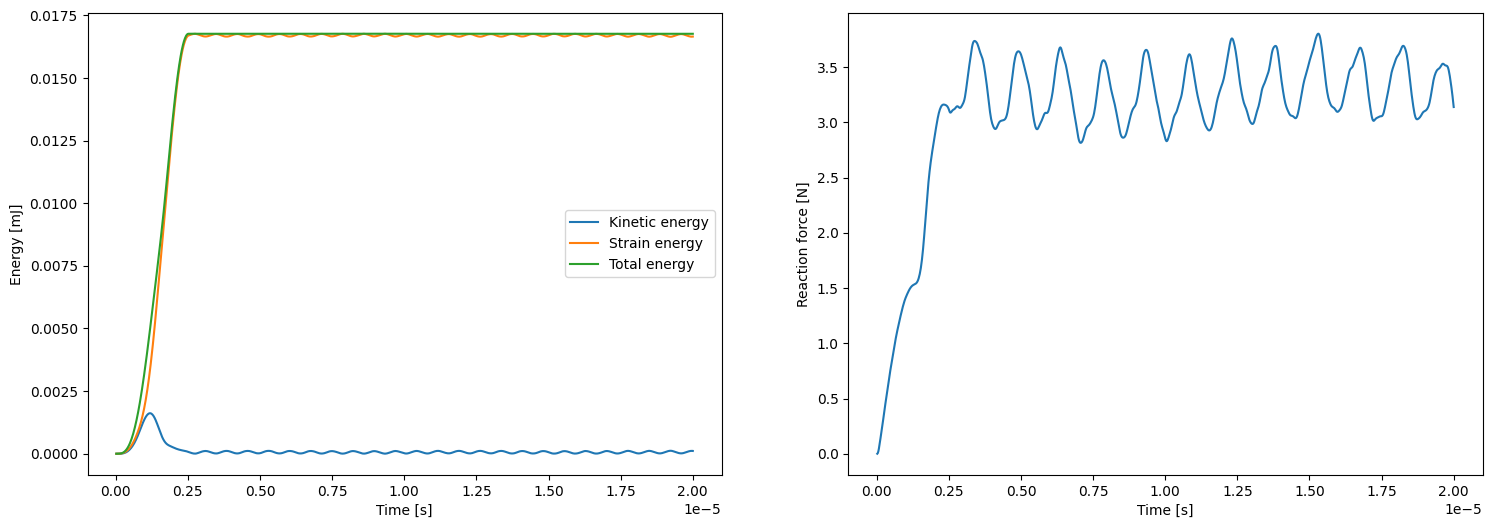

In [13]:
fig2, ax2 = plt.subplots(1, 2, figsize=(18,6))

ax2[0].plot (t_, P_kin_, label = 'Kinetic energy')
ax2[0].plot (t_, P_str_, label = 'Strain energy')
ax2[0].plot (t_, P_tot_, label = 'Total energy');
ax2[0].set_xlabel('Time [s]')
ax2[0].set_ylabel('Energy [mJ]')
ax2[0].legend()

ax2[1].plot (t_, Fx_react_right_)
ax2[1].set_xlabel('Time [s]')
ax2[1].set_ylabel('Reaction force [N]');